## The goal of this notebook is to train classifiers for PET, T1 and Generated PET images

## Training in low data regime, so I've done my best to avoid overfitting.

PET data are crop centered and downsampled to half of their dimensions. Images are scaled indipendently to 0,1 <br>
Random Gaussian Noise, Flip and gaussian smoothing are augmentations used in training phase <br>

The model is a Classifier based on depthwise separable convolutions. <br>
The last layer is a BayesianLinear liner, so instead of learning the optimal parameter, the model try to learn a distribution of parameters. This is equivalent to infinite network ensembling. <br>
Adam optimizer is used with class weight to deal with unbalanced classes and regularization on weight_decay to deal with overfitting


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob
from os.path import join as opj
from mpl_toolkits.axes_grid1 import ImageGrid
from unet3D import *
from torchsummary import summary
import monai
from monai.transforms import *
from mpl_toolkits.axes_grid1 import ImageGrid
import ssim
import tqdm

from sklearn.model_selection import train_test_split
import wandb
wandb.login()
from network import *
from torchvision.utils import make_grid

from monai.networks.nets import *

from sklearn.metrics import classification_report
import torchbnn as bnn

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (torvergatafmri). Use `wandb login --relogin` to force relogin


In [2]:
base_path="/home/matteo/data/MRI-PET-AI"
config={}

cases=os.listdir(base_path)
exclude=['Scripts','temp','SubjectList.txt','Bay_7_Reconstruction_Log.xlsx','PBRKOA_KOA003_010818']

cases=[i for i in cases if i not in exclude]

In [3]:
label_dict={"HC":0, "CLB":1, "KOA":2}
labels=[]
for c in cases:
    cl=None
    if "HC" in c:
        cl="HC"
    elif "CLB" in c:
        cl="CLB"
    elif "KOA" in c:
        cl="KOA"
    if cl is not None:
        labels.append(label_dict[cl])

In [4]:
cases=[os.path.join(base_path,i) for i in cases if i not in exclude]
len(labels),len(cases)

(204, 204)

In [5]:
train_cases,test_cases,train_labels,test_labels=train_test_split(cases,labels,test_size=0.20,random_state=42)
# train_cases,val_cases,train_labels,val_labels=train_test_split(cases,labels,test_size=0.2)


print(f"[INFO] train cases: {len(train_cases)} test cases: {len(test_cases)}")

[INFO] train cases: 163 test cases: 41


In [6]:
class_weights=[1-np.sum(np.array(train_labels)==i)/len(train_labels) for i in range(len(set(label_dict.values())))]
class_weights

[0.8711656441717791, 0.5705521472392638, 0.558282208588957]

In [7]:
# print(f"[INFO] train unbalance: {np.sum(train_labels)/len(train_labels)} test unbalance: {np.sum(test_labels)/len(test_labels)}")

In [8]:
class MRIPETDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels,roi=(96,96,96),modality="PET", transform=None, target_transform=None,out_mask=False):
        self.paths = paths
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
        self.roi=roi
        self.out_mask=out_mask
        self.modality=modality
        
        
    def __len__(self):
        return len(self.paths)
    

    def __getitem__(self, idx):
        
        images_path=glob.glob(opj(self.paths[idx],"*.nii.gz"))
        t1_path=[i for i in images_path if "T1" in i][0]
        pet_path=[i for i in images_path if "_suv_" in i][0]
        
        t1=nib.load(t1_path)
        pet=nib.load(pet_path)
        
        assert t1.shape==pet.shape
        half_shape=[s//2 for s in t1.shape]
        half_roi=[s//2 for s in self.roi]
        dim_0_start=half_shape[0]-half_roi[0]
        dim_0_end=half_shape[0]+half_roi[0]

        dim_1_start=half_shape[1]-half_roi[1]
        dim_1_end=half_shape[1]+half_roi[1]

        dim_2_start=half_shape[2]-half_roi[2]
        dim_2_end=half_shape[2]+half_roi[2]
        
        ##choose what data we need to load
        label=self.labels[idx]
        
        if self.modality=="PET":
            pet=pet.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
            pet=torch.Tensor(np.expand_dims(pet,0))
            if self.target_transform:
                pet = self.target_transform(pet)
                
            return pet,label
                
                
            
        elif self.modality=="MRI":
            t1=t1.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
            t1=torch.Tensor(np.expand_dims(t1,0))
            if self.transform:
                t1 = self.transform(t1)
                
            return t1,label
        
        elif self.modality=="both":
            pet=pet.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
            pet=torch.Tensor(np.expand_dims(pet,0))
            if self.target_transform:
                pet = self.target_transform(pet)
                
            t1=t1.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
            t1=torch.Tensor(np.expand_dims(t1,0))
            if self.transform:
                t1 = self.transform(t1)
            

            if self.out_mask:
                mask=(t1>0)*1.
                return t1,pet,mask,label
            else:
                return t1,pet, label
        

        
        
        
        
        


In [24]:
BS=16
modality="PET"
config["BS"]=BS
config["modality"]=modality

transform_mri=Compose([ScaleIntensityRangePercentiles(1,99,0,1)])
transform_pet=Compose([Spacing(pixdim=(2,2,2),image_only=True),
                       ScaleIntensity(0,1),
                       RandFlip(0.3,spatial_axis=[1,2,]),
                       RandGaussianSmooth(sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), prob=0.1),
                      ])

transform_pet_test=Compose([Spacing(pixdim=(2,2,2),image_only=True),
                       ScaleIntensity(0,1),])

#transform_pet=None

train_dataset=MRIPETDataset(train_cases,train_labels,modality=modality,transform=transform_mri,target_transform=transform_pet)
test_dataset=MRIPETDataset(test_cases,test_labels,modality=modality,transform=transform_mri,target_transform=transform_pet_test)


train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=BS,shuffle=True)




In [12]:
x,y=next(iter(train_dataset))

x.shape,x.max(),x.min()
in_shape=x.shape

In [13]:
channels=[32,64,128]
kernel_size=3

config["channels"]=channels
config["kernel_size"]=kernel_size


model=BayesianClassifier(in_shape=in_shape,classes=len(set(label_dict.values())),channels=channels,strides=[2,2,2],kernel_size=kernel_size,depthwise=True)

In [14]:
summary(model,in_shape,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 24, 24, 24]             224
            Conv3d-2        [-1, 1, 24, 24, 24]              28
            Conv3d-3        [-1, 8, 24, 24, 24]              16
    DepthSepConv3d-4        [-1, 8, 24, 24, 24]               0
    InstanceNorm3d-5        [-1, 8, 24, 24, 24]               0
             PReLU-6        [-1, 8, 24, 24, 24]               1
            Conv3d-7        [-1, 8, 24, 24, 24]             224
            Conv3d-8        [-1, 8, 24, 24, 24]              72
    DepthSepConv3d-9        [-1, 8, 24, 24, 24]               0
   InstanceNorm3d-10        [-1, 8, 24, 24, 24]               0
            PReLU-11        [-1, 8, 24, 24, 24]               1
     ResidualUnit-12        [-1, 8, 24, 24, 24]               0
           Conv3d-13       [-1, 16, 12, 12, 12]           3,472
           Conv3d-14        [-1, 8, 12,

In [15]:
device="cuda:0"

model.to(device)

BayesianClassifier(
  (net): Sequential(
    (layer_0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): DepthSepConv3d(
            (depthwise_separable_conv): Sequential(
              (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (1): Conv3d(1, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            )
          )
          (adn): ADN(
            (N): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): DepthSepConv3d(
            (depthwise_separable_conv): Sequential(
              (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=8)
              (1): Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
            )
          )
          (adn): ADN(
            (N): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False

In [18]:
criterion=nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))
optim=torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=1e-3)

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

In [19]:
wandb.init(project="MRI2PET",config=config)

In [20]:
EPOCHS=50
save_model=1
outdir="models/class_pet"
os.makedirs(outdir,exist_ok=True)

loss_history=[]
val_loss_history=[]
# pbar=tqdm.tqdm(range(EPOCHS))
for epoch in range(EPOCHS):
    
    ## TRAINING
    loss_tmp=[]
    val_loss_tmp=[]
    
    pbar=tqdm.tqdm(train_dataloader)
    epoch_acc=[]
    y_list=[]
    y_pred_list=[]
    for x,y in pbar:
        
        optim.zero_grad()
        x,y=x.to(device),y.to(device)
        y_pred=model(x)

        y_pred_list.append(y_pred.detach().cpu())
        y_list.append(y.cpu())
        
        
        #compute bayesian_loss
        loss=criterion(y_pred,y)
        kl = kl_loss(model)
        
        loss = loss + kl_weight*kl
        
        loss.backward()
        optim.step()
        
        pbar.set_description(f"epoch {epoch} loss: {loss.item()}")
        loss_tmp.append(loss.item())
        wandb.log({"loss":loss.item()})
        
    loss_history.append(np.mean(loss_tmp))
    y_list=torch.cat(y_list,0)
    y_pred_list=torch.cat(y_pred_list,0)
    
    acc=(y_list==y_pred_list.argmax(dim=1)).sum()/len(y_list)
    wandb.log({"train_acc": acc})
    epoch_acc.append(acc.numpy())
    
        
    ## VALIDATION
    
    with torch.no_grad():
        pbar_val=tqdm.tqdm(test_dataloader)
        y_list=[]
        y_pred_list=[]
        
        for x,y in pbar_val:
        
        
            x,y=x.to(device),y.to(device)
            y_pred=model(x)


            #compute masked_loss
            loss=criterion(y_pred,y)
            kl = kl_loss(model)
        
            loss = loss + kl_weight*kl
            
            y_pred_list.append(y_pred.detach().cpu())
            y_list.append(y.cpu())

            pbar_val.set_description(f"val epoch {epoch} val loss: {loss.item()}")
            val_loss_tmp.append(loss.item())
            wandb.log({"val_loss":loss.item()})
            
        y_list=torch.cat(y_list,0)
        y_pred_list=torch.cat(y_pred_list,0)
        val_loss_history.append(np.mean(val_loss_tmp))
        acc=(y_list==y_pred_list.argmax(dim=1)).sum()/len(y_list)
        wandb.log({"val_acc": acc})
    
    
    
    if epoch%save_model==0:
        ## SAVE MODEL
        torch.save(model.state_dict(),f"{outdir}_{epoch}.pt")
    
    

epoch 31 loss: 3.5690062046051025:  73%|███████████████████████▎        | 8/11 [00:21<00:08,  2.75s/it]


KeyboardInterrupt: 

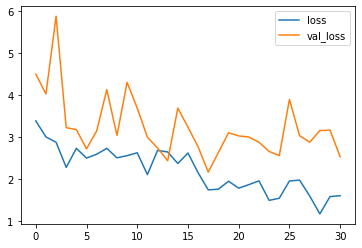

In [21]:
plt.plot(loss_history,label="loss")
plt.plot(val_loss_history,label="val_loss")
plt.legend()

In [22]:
print(classification_report(y_list.numpy(),y_pred_list.argmax(dim=1).numpy()))


AttributeError: 'list' object has no attribute 'numpy'

## Averaged Predictions

In [25]:
y_pred_val=np.array([])
y_pred_val_std=np.array([])


y_val=np.array([])

averages=100

soft=nn.Softmax(dim=1)

with torch.no_grad():
    for x,y in tqdm.tqdm(test_dataloader):
        
        guess=[]
        for i in range(averages):
            x=x.to(device)
            guess.append(soft(model(x)).cpu().numpy())
        y_pred_val=np.append(y_pred_val,np.array(guess).mean(axis=0))
        y_pred_val_std=np.append(y_pred_val_std,np.array(guess).std(axis=0))
        
        y_val=np.append(y_val,y)

y_pred_val=y_pred_val.reshape((-1,3))
y_pred_val_std=y_pred_val_std.reshape((-1,3))

y_val=y_val.reshape((len(y_pred_val),-1))

print("ORIGINAL")
print(classification_report(y_val.squeeze(),np.argmax(y_pred_val,-1)))



100%|████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.26s/it]

ORIGINAL
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.57      0.84      0.68        19
         2.0       0.62      0.53      0.57        15

    accuracy                           0.59        41
   macro avg       0.40      0.46      0.42        41
weighted avg       0.49      0.59      0.52        41




/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [32]:
keep_if_below=0.4

print("COMPUTING TRUSTHWORTHY PREDICTIONS")
valid_pred=[]
valid_true=[]
for j in range(len(y_pred_val)):
    idx=np.argmax(y_pred_val[j])
    if y_pred_val_std[j][idx]<keep_if_below:
        valid_pred.append(idx)
        valid_true.append(y_val[j])
print(f"[INFO] The network is valid is {len(valid_pred)/len(y_pred_val)}")
print(classification_report(valid_true,valid_pred))
        

COMPUTING TRUSTHWORTHY PREDICTIONS
[INFO] The network is valid is 0.6829268292682927
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.65      0.87      0.74        15
         2.0       0.62      0.62      0.62         8

    accuracy                           0.64        28
   macro avg       0.42      0.50      0.46        28
weighted avg       0.53      0.64      0.58        28



/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [ ]:
y_pred_val_std